In [1]:
import numpy as np 
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error as mse

In [2]:
#read csv files, there is no ID columns 
X=pd.read_csv("train_features.csv")
y=pd.read_csv("train_targets.csv")
test=pd.read_csv("test_features.csv")

In [3]:
def pre_process(dataframe):
    print(dataframe.head())
    print(dataframe.tail())
    print(dataframe.shape)
    print(dataframe.info())

    #convert objects to numerical values sex, smoker, and region 
    dataframe['sex']=dataframe['sex'].map({'female':0, 'male':1})
    dataframe['smoker']=dataframe['smoker'].map({'no':0, 'yes':1})
    dataframe['region']=dataframe['region'].map({'northeast':0, 'southwest':1,'southeast':2, 'northwest':3})
    dataframe.isnull().sum()
    return dataframe
    


In [4]:
#check null values


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [5]:
#overall statistics
X.describe()

,age,bmi,children
count,900.000000,900.000000,900.000000
mean,39.147778,30.692950,1.094444
std,13.920454,6.120561,1.208504
min,18.000000,15.960000,0.000000
25%,27.000000,26.400000,0.000000
50%,39.000000,30.302500,1.000000
75%,51.000000,34.800000,2.000000
max,64.000000,53.130000,5.000000


In [6]:
#do preprocessing on data_frame X
X = pre_process(X)  

   age     sex     bmi  children smoker     region
0   40  female  25.460         1     no  northeast
1   18    male  39.140         0     no  northeast
2   55  female  29.700         2     no  southwest
3   64  female  35.970         0     no  southeast
4   34    male  21.375         0     no  northeast
     age     sex    bmi  children smoker     region
895   50    male  26.41         0     no  northwest
896   23  female  32.78         2    yes  southeast
897   62  female  26.29         0    yes  southeast
898   63    male  21.66         1     no  northwest
899   18  female  21.66         0    yes  northeast
(900, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       900 non-null    int64  
 1   sex       900 non-null    object 
 2   bmi       900 non-null    float64
 3   children  900 non-null    int64  
 4   smoker    900 non-null    obje

split data intrp training and testing sets
train model on training set 
test model on testing set

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
#model training 
rf = RandomForestRegressor()
rf.fit(X_train,y_train.values.ravel())
gr = GradientBoostingRegressor()
gr.fit(X_train,y_train.values.ravel())

GradientBoostingRegressor()

In [10]:
y_pred1 = rf.predict(X_test)
y_pred2 = gr.predict(X_test)

df1 = pd.DataFrame({'Actual':y_test.values.flatten(),'rf':y_pred1,'gr':y_pred2})

In [11]:
df1

,Actual,rf,gr
0,12233.82800,13603.876414,15272.924939
1,4428.88785,14099.552398,7693.051392
2,37133.89820,37327.656322,38119.251057
3,7749.15640,7450.448008,9947.358685
4,4149.73600,7917.297837,5339.125885
...,...,...,...
175,27808.72510,27822.099602,27391.643586
176,6356.27070,12650.902863,7643.484655
177,8782.46900,11857.121681,11046.355330
178,18157.87600,6329.778999,7249.466026


In [12]:
import matplotlib.pyplot as plt

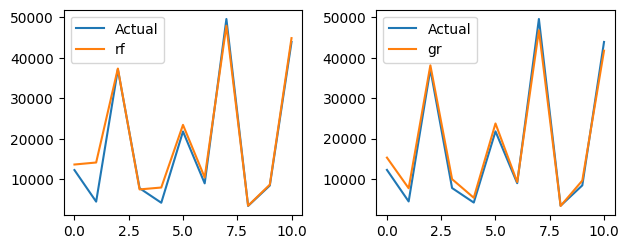

In [13]:
plt.subplot(223)
plt.plot(df1['Actual'].iloc[0:11],label='Actual')
plt.plot(df1['rf'].iloc[0:11],label="rf")
plt.legend()

plt.subplot(224)
plt.plot(df1['Actual'].iloc[0:11],label='Actual')
plt.plot(df1['gr'].iloc[0:11],label="gr")

plt.tight_layout()

plt.legend()

In [14]:
gr = GradientBoostingRegressor()
gr.fit(X,y.values.ravel())

GradientBoostingRegressor()

Prediction

In [15]:
def predict(test, model):
    predictions = model.predict(test) # predicting the data using model
    return predictions

In [16]:
# 5Fold CV gives 5 different model and 5 different model provides 5 different value for one component
# For reaching better solution we take average of them
def get_average(values):
  average_for_out = np.zeros((80, 595))
  for i in range(5):
    average_for_out += np.array(values[i])
  average_for_out = np.true_divide(average_for_out, 5)
  return average_for_out

In [17]:
def write_output(filename,predictions):
    with open(filename, mode='w', newline='') as output_file: # opening file
        output_writer = csv.writer(output_file, delimiter=',') # csv writer
        output_writer.writerow(["ID", "predicted"]) # writning header
        for i in range(len(predictions)):
            output_writer.writerow([i, predictions[i]])

In [19]:
import time
from sklearn.ensemble import GradientBoostingRegressor
def K5Fold(X, y):
    mseList = [] # list to keep MSEs of each fold
    startTime = time.time() # start time
    kFold = KFold(n_splits=5) # 5-fold CV
    foldNo = 1
    for train_index, test_index in kFold.split(X):
        X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index] # samples of current fold
        Xtrain_processed = pre_process(X_train)
        Xtest_processed = pre_process(X_test)
        print("Fold: ", foldNo) # printing fold number
        model = GradientBoostingRegressor() # training the model
        model.fit(Xtrain_processed, y_train.values.ravel())
        prediction = predict(Xtest_processed, model) # predicting the test samples
        FMse = mse(prediction.flatten(), y_test.to_numpy().flatten()) # calculating MSE of current fold
        print("MSE Result: ", FMse)
        print()
        mseList.append(FMse) # appending fold mse to mse list
        foldNo += 1
    print("Total time passed in 5-Fold CV: ","{:.2f}".format((time.time()-startTime))) # printing total time passed
    print("Mean of MSEs:",np.mean(mseList)) # printing the mean of all mses of folds


K5Fold(X,y)
print("Training with samples and predicting test samples")
model =GradientBoostingRegressor() # training the model
model.fit(X,y.values.ravel()) # training model for prediction
X_test_for_submission = pre_process(test)
prediction = predict(X_test_for_submission,model) # predicting using test data
write_output("predictions.csv", prediction.flatten()) # writing predictions to csv file
print("Done.")

     age  sex    bmi  children  smoker  region
180   47    0  32.00         1       0       1
181   23    1  35.20         1       0       1
182   29    1  29.64         1       0       0
183   19    0  24.70         0       0       1
184   23    0  23.18         2       0       3
     age  sex    bmi  children  smoker  region
895   50    1  26.41         0       0       3
896   23    0  32.78         2       1       2
897   62    0  26.29         0       1       2
898   63    1  21.66         1       0       3
899   18    0  21.66         0       1       0
(720, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 180 to 899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       720 non-null    int64  
 1   sex       720 non-null    int64  
 2   bmi       720 non-null    float64
 3   children  720 non-null    int64  
 4   smoker    720 non-null    int64  
 5   region    720 non-null    int64  
dtypes: f

ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values